Our second try on the DengAI Data Science Challenge

## Background

The problem we are tackling comes from a Data Science Challenge from DrivenData.org. To be more specific, we are talking about the DengAI forecasting challenge, which can be read up on [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

In this challenge we are asked to predict the number of dengue fever in the two cities San Juan and Iquitos given time-series data of several feature variables with around ~900 and ~500 observations for each city respectively.
Given that dengue fever is transmitted by mosquitoes, most features are related to environmental factors such as temperature and precipitation. Especially challenging in this competition is, that we are asked to provide forecasts for around ~250 and ~150 observations in the future respectively. The long-term forecast seems especially challenging when considering that we do not have that many observations to train our model. 

This challenge definitely is one of the more popular ones on DrivenData.org, having more than 9000 participating teams as of March 2021.

## Structure of this post

We begin this post by taking a look at the target variable and discuss what makes the prediction of that time-series so difficult. Afterwards we discuss our key learnings from our last attempt on this challenge and what we aim to improve this time.

The second part of this post then discussing the prediction methodology and shows its implementation into code. 


### Target variable

One of the first steps before deciding on the strategy of the forecasting methodology is to take a thorough look at the target variable. For this challenge it is to note that we actually have panel data. That means we have time-series data for multiple entities, namely for the two cities San Juan and Iquitos.

When facing panel data, the question arises whether we build one model for each entity, or whether we use one model for both entities. This question is normally answered by comparing the data generating process between entities. If the distribution between entities is fundamentally different, then any prediction model will have a hard time trying to predict to significantly different time-series.

Using a Kolmogrov Smirnov test, which checks whether two distributions are significantly different of one another, we conclude that it would be the best to train two different models.

In order to get a first idea of the target variable we are facing, we show in the following the target variable for both cities: San Juan (left) and Iquitos (right).

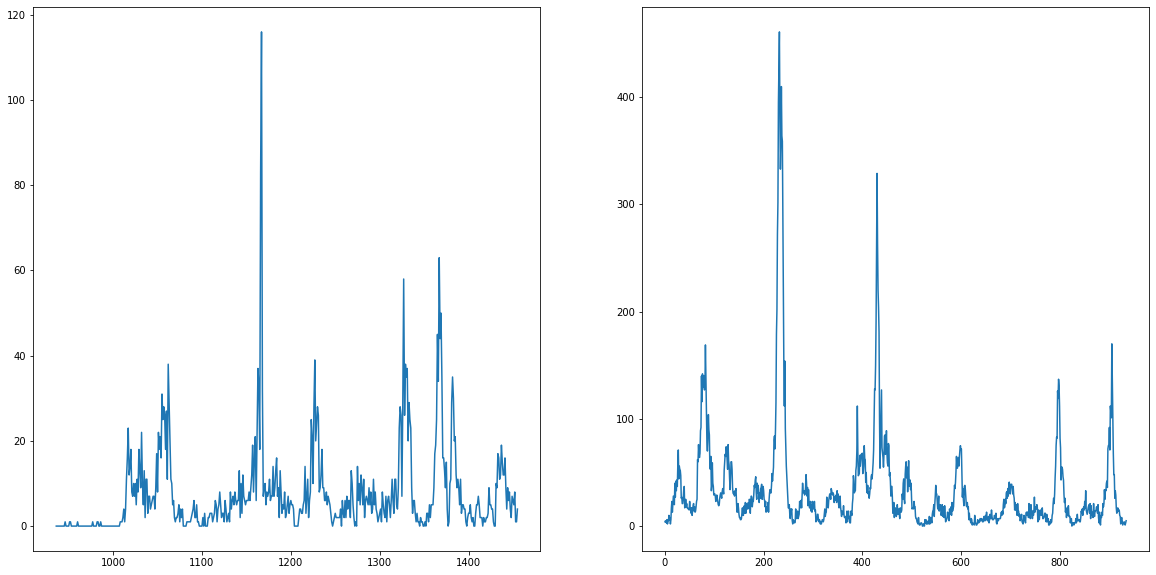

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(r"/Users/PM/Documents/Projects/dengai_ensemble/")
target_data = pd.read_csv("data/dengue_labels_train.csv")

city_names = set(target_data.loc[:, "city"])
n_cities = len(city_names)
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    axs[i].plot(city_data) 

From the chart above we can nicely see that both time series follow a somewhat yearly seasonality. That would make sense as we would assume that the mosquito population is peaking every summer and nearly extinct in the winter times. What is even more apparent are the massive spikes in the time series. It seems that in a non-periodic cycle the number of dengue fever cases just explode.

Given the magnitude of those spikes, failing to predict them makes all the difference between a good and a bad prediction model.

## Learnings from previous attempt

Given that we already tried ourselves on the DengAI challenge in the past, it is worthwhile to talk about what has been tried, what went wrong and what could be improved for the next attempt.

During our last attempt we build a [STL Forecasting model](https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html) with an underlying ARIMA model. The ARIMA was parameterized using the Box-Jenkins methodology, which is the go-to method when doing that.

The flaw of this model, or any ARIMA model for that matter, is that those models are not designed for long-term forecasts. That is because ARIMA models are mean-reverting and therefore useless when it comes to forecasts longer than a few periods. Especially with time-series which are as bumpy as the ones we are trying to predict, this forecasting method was wrongly placed.

Below we see that out-of-sample predictions from our model for the city San Juan. The out-of-sample prediction were produced by using the first 80% of the data for training purposes and applying the parameterized model then on the remaining 20%.

![Forecasting for out-of-sample San Juan](images/last_attempt_forecast.png)

One positive aspect of our last attempt was to allow multiple seasonalities through the STL part of the model. STL or *seasonal-trend decomposition using LOESS* is normally used to decompose a time series into its three components: seasonality, trend and residual. Splitting a time-series into its components comes handy when trying to make the series stationary, which normally would involve removing the trend and potentially even its seasonality.

The benefit of allowing for multiple seasonalities becomes particularly apparent when plotting a power-spectrum for both time-series. A power-spectrum gives us an idea what the driving frequencies of a series are. This concept is easier understood when imaging that we are not dealing with dengue cases over time, but rather with the the sound wave of a song. All (interesting) songs consist out of multiple different sounds, which are all reflected within the song wave. Looking at the sound wave, it is difficult though to know which sound frequency is the most dominant one. In order to split the sound wave into its frequency components we are using a so-called [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform). The highest peaking frequency, also known as the frequency with the highest magnitude is then said to drive the sound. It could also of course be that there are multiple dominant frequencies.

This concept is also applicable to time-series problems in order to find out which seasonality is dominant within the series. The following code plots the power-spectrum for the two time-series. One critical question is which threshold level we would use from which onwards we would describe a frequency as *prominent*. This question normally heavily depends on the context, but will always end up being subjective. We decided to set the threshold at three standard deviations above the median. We chose the median in contrast to using the mean, given the heavy skewness the time-series suffers from.

The relevant frequencies for iq is/are: []
The relevant frequencies for sj is/are: [187.2, 93.6, 52.0]


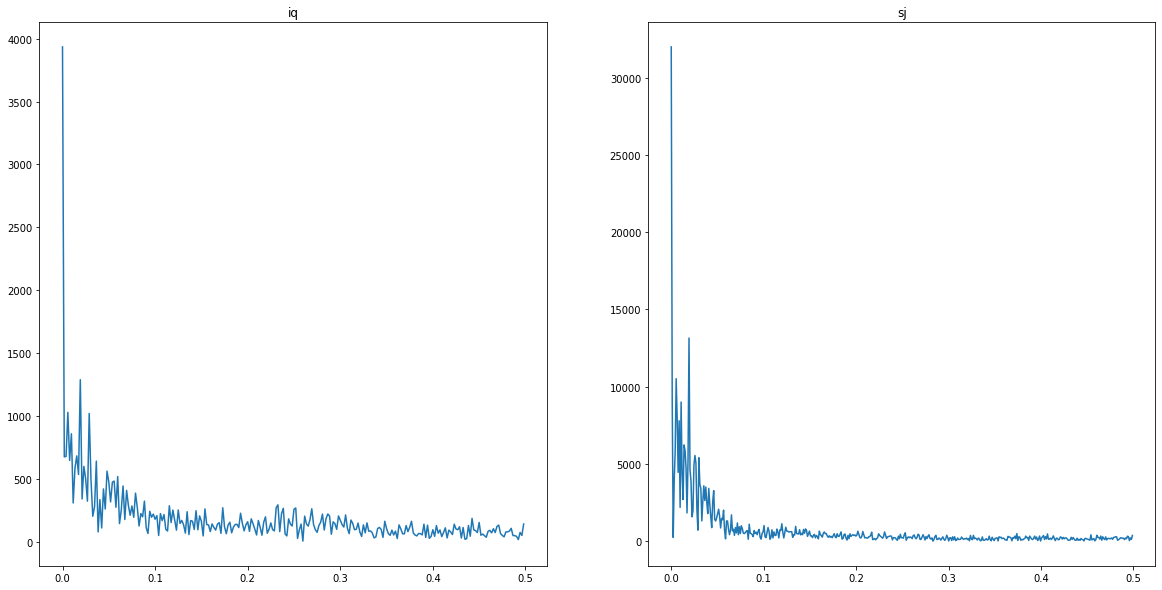

In [15]:
import numpy as np
from scipy import signal as sig

city_data = target_data.query("city==@city").loc[:, "total_cases"]

fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    signal = target_data.query("city==@city").loc[:, "total_cases"]

    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.fft.fftfreq(len(signal))

    left_magnitude = magnitude[:int(len(magnitude)/2)]
    left_frequency = frequency[:int(len(frequency)/2)]

    prominence = np.median(left_magnitude) + 3 * np.std(left_magnitude)
    peaks = sig.find_peaks(left_magnitude[left_frequency >= 0], prominence=prominence)[0]
    peak_freq = left_frequency[peaks]
    list_frequencies = (1/peak_freq).tolist()

    axs[i].plot(left_frequency, left_magnitude)
    axs[i].set_title(city)
    print(f"The relevant frequencies for {city} is/are: {list_frequencies}")

From the print statement above we see that even though we do not find any driving seasonality for Iquitos, we find three frequencies for San Juan which are deemed prominent enough.

Given that finding we are also using a time-series prediction model which can input multiple seasonalities.

## Forecasting Methodology

The inspiration for our approach came during one of the brain-storming sessions I had at work. At the time we were working for a large insurance company and were building a claims forecasting model.

The business model of an insurer relies on the foundations that most people do not have to make use of their insurance most of the time. That means that in most months the customers of an insurer simply pays into the insurance without filling any claims. That means that most entries of the claims data of an insurance are zero. A phenomena which we would describe as "sparse" data.

That sparsity makes it significantly more difficult to predict the variable. Academia provides us with several suggestions on how to tackle this problem. One potential approach to model that behavior is suggested in the paper of Andrea Andrea Dal Pozzolo 2010 [1]. Herein the author splits the forecasting problem into two different parts. Firstly, a classification problems in which we classify whether the claim is having a payout or not. In the second step we apply a regression model to the observations which are non-zero.

The benefit of this approach is that the regression model could focus more on observations which are non-zero and therefore is able to better cope with the spikes within the target.

Applying this approach on our data is not as straightforward. That is mainly because of two reasons: 

1. In contrast to the insurance claims data we do not find many observations within the dengue fever target which are zero
2. In contrast to the outlined paper we face time-series data instead of cross-sectional data

To address those problems the following idea was drafted. Instead of trying to figure out which observations are non-zero, we try in a first instance to figure out which observation belongs to one of the spikes.

We do that by separating the target variable into *outliers* and *non-outliers*. For example, we define every observation above the e.g. 90th percentile as outliers and all of the other observations as non-outliers. By doing that we turned the target variable from an integer to a binary, which allows us to apply a classification model. Afterwards, we apply a regression model on only those observations which are predicted to belong to the *outliers* class.

Below we show how exactly that separation would look like when using the 90th percentile as the threshold between *outliers* and *non-outliers*.

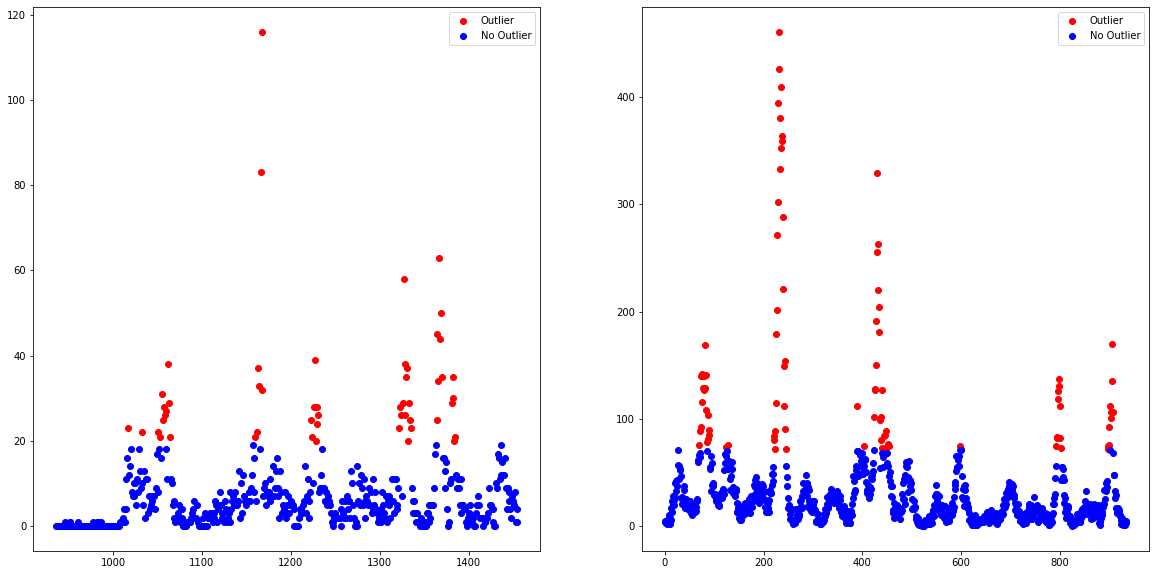

In [16]:
import numpy as np

THRESHOLD = 90
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    level_threshold = np.percentile(city_data, THRESHOLD)
    bool_threshold = city_data > level_threshold
    axs[i].plot(city_data[bool_threshold], color="red", label="Outlier", linestyle="None", marker="o")
    axs[i].plot(city_data[~bool_threshold], color="blue", label="No Outlier", linestyle="None", marker="o")
    axs[i].legend()

The other problem we are facing is that we are dealing with a time-series problem in contrast to a cross-sectional problem we had in the insurance context.

This problem is solved by initially ignoring the time component of our problem and simply treating the classification problem as it were cross-sectional. Afterwards our treatment differs for the observations which were labeled *outliers* compared to how we proceed to the ones which were labeled as *non-outliers*.

As already mentioned earlier, the observations which are said to be *outliers* are predicted using a regression model. The majority of our observations end up being *non-outliers* though, and for those it is important to respect the time component. As seen through by the power-plot, it would be also beneficial to apply a model which can handle multiple seasonalities. We therefore decided to predict the *non-outliers* with an exponential smoothing model called TBATS. The exact workings of this model are beyond the scope of this article and will therefore be outlined in a different post. On a high level TBATS takes its roots in exponential smoothing methods.

## Oversampling
Given that we are separating our data into *outliers* and *non-outliers* by splitting the dataset at the e.g. 90th percentile, we will by definition end up with a highly imbalanced dataset. This would impact our model-performance, as the model does not have a sufficient amount of *outliers* observations to properly learn which statistical properties constitute the concept of *outliers*.

In order to combat that problem, there are multiple approaches of how to tackle that. We could for instance undersample the majority class (i.e. *non-outliers*), or alternatively, oversample the minority class. We decided to go with the later approach, but use a synthetic oversampler instead of using random sampling.

Synthetic minority oversampling describes a technique in which new observations of the minority classes are created by finding observations which are “like” the existing ones, but are not completely identical. One of the most popular methods is called SMOTE, which stands for Synthetic Minority Oversampling Technique.

The exact workings and visualization of how SMOTE works will be outlined in a separate post, but the basic idea is quickly understood: One imagines that we only have two features and we plot all observations on a scatter plot, having each feature on one axes. The next step is then to draw connecting lines between every observation. The newly created values would then be found on these connection lines. This strategy is only one of many potential ways of how to use the SMOTE oversampling technique.

One quite important parameter within all oversample techniques is called the sampling_strategy. This parameter describes how big the minority class should grow in compared to the majority class. If we for example have a minority class which represents 10% of the amount of the majority class and we specify a sampling_strategy of 0.5, then we would create 40 percentage points more of the minority class.

In the original paper of SMOTE it is suggested that a combination of oversampling of the minority class and undersampling the majority class leads to favorable results. For now we only grid-search over a sampling strategy of 0.5 and 1.

## Code Implementation

After covering the overall concept, it is now time to see how the high level code implementation looks like.

As already mentioned in the beginning of the blogpost, this post does not intend to elaborate too much on the individual pre-processing functions and classes, but rather discusses the overall modeling approach. In order to give a better understanding of what is happening in the background of the feature engineering pipeline, we wrote a different post which is elaborating on that.

We start by importing all the relevant packages for this project, including packages from other self-written classes and functions.

In [17]:
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              RandomForestRegressor, GradientBoostingRegressor)
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from src._classes import (Encoding, ColumnCorrection, Transformer, Stationarity, Imputer, FeatureCreation,
                          FeatureSelection, TBATSWrapper, ModelSwitcher)
from src._functions import (city_query, find_top_n_obs, winsorize_data, plot_confusion_matrix,
                            combining_models, plot_prediction_results)
import src._config # Contains matplotlib settings to be applied to all graphs


/Users/PM/.local/share/virtualenvs/dengai_ensemble-MOIVDowa/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Potentially worth highlighting is that we are not using the *make_pipeline* function from scikit-learn, but rather the version from the *imblearn* package. The reason for that is that when using any over-/downsampling algorithm from imblearn, the classical scikit-learn pipeline does not work. In order to fix that, the guys from imblearn came up with their own version of pipeline function, which works equally in all respects but allows for over-/downsampling methods.

Next up would be to specify the parameters which feed into the pipeline. Here we will define for example how many cross validations are conducted, what the maximum lag within the feature creation is going to be and so on.

Note that we are choosing *precision* as the classification scoring method since we are more worried about False Positives than False Negatives. This is because of theoretical as well as empirical reasons.

When experimenting with different classification models we note that the model labels significantly more observations as *outliers* even though they are not, than the other way around. Given this behavior of being more prone towards to False Positive mistakes it would make sense to fight against that, using the *precision* scoring function.

Secondly, labeling an observation as an *outlier* even though it is none would trigger a spike, which is much riskier compared to having a moderate value when it should be a spike.

When it comes to the error metric for the regression problem we decided to go for the very same metric as the entire Data Challenge DrivenData.org applies, namely *Mean Absolute Error*.

In [18]:
# Pipeline settings
cv = 3
N_NEIGHBOURS = 10
DEGREE = 2
MAX_LAG = 4
SIGNIFICANCE_LEVEL = 5 / 100
RS = 42
e_list = [0.01, 0.05, 0.1, 0.25, 0.5]
clf_scoring = "precision"
reg_scoring = "neg_mean_absolute_error"

### Classification Pipeline

The next step is now to set up the first step of the forecasting methodology, which is the pipeline for predicting whether the observation belongs to the *outlier* class.

Therefore, when creating the pipeline we have to be aware of two things. Firstly, we have to specify that we are facing a classification problem within the **FeatureSelection**. Secondly we have to include our over-sampling class we have to specify that we are dealing with a classification problem compared to a regression problem.

Furthermore, we are specifying an oversampling algorithm SMOTE into the pipeline, given that by the very nature of predicting *outliers* we do not have many observations of the *outliers* class. In order to be a bit more flexible on the amount of oversampling, we allow for the *sampling_strategy* values of 0.5 and 1 within the gridsearch.

Given that we would like to try multiple forecasting models with the pipeline, we apply the trick of creating a **ModelSwitcher** class which can intake different models as hyper-parameters within a gridsearch operation. This concept is further elaborated on within the other post of this series.

The range of models we would like to try are stated below as well. Given that the feature-selection class needs a prediction model specified as well, in order to find the optimal value for *e* (the purpose of which explained in the pipeline post) we have to specify the model twice. Given run-time considerations we only allow for a minimal amount of hyper-parameters for each model.

In [19]:
# Classification Pipeline
clf_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG),
    FeatureSelection(e_list=e_list, scoring=clf_scoring, clf=True),
    SMOTE(random_state=RS),
    ModelSwitcher()
)

clf_parameters = [
    {"modelswitcher__estimator": [svm.SVC(random_state=RS)],
     "modelswitcher__estimator__C": [0.1, 1, 5],
     "featureselection__estimator": [svm.SVC(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},

    {"modelswitcher__estimator": [LogisticRegression(random_state=RS)],
     "modelswitcher__estimator__C": [0.1, 1, 2],
     "featureselection__estimator": [LogisticRegression(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},

    {"modelswitcher__estimator": [RandomForestClassifier(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10],
     "featureselection__estimator": [RandomForestClassifier(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},

    {"modelswitcher__estimator": [GradientBoostingClassifier(random_state=RS)],
     "modelswitcher__estimator__learning_rate": [0.05, 0.1, 0.2],
     "featureselection__estimator": [GradientBoostingClassifier(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},
]

clf_gscv = GridSearchCV(estimator=clf_pipeline, param_grid=clf_parameters, scoring=clf_scoring, cv=cv)


### Regression Pipeline

The pipeline for the regression part of this forecasting is pretty similar to the pipeline used for classification purposes. The main differences being only that we do not need any oversampling method and that we are now initializing regression instead of classification models.

In [ ]:
# Regression Pipeline
reg_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG, lagged_features=False),
    FeatureSelection(e_list=e_list, scoring=reg_scoring, clf=False),
    ModelSwitcher()
)

reg_parameters = [
    {"modelswitcher__estimator": [LinearRegression()],
     "featureselection__estimator": [LinearRegression()]},

    {"modelswitcher__estimator": [RandomForestRegressor(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10, 25, 50],
     "featureselection__estimator": [RandomForestRegressor(random_state=RS)]},

    {"modelswitcher__estimator": [GradientBoostingRegressor(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10],
     "modelswitcher__estimator__max_depth": [3, 5, 10],
     "modelswitcher__estimator__learning_rate": [0.1, 0.2],
     "featureselection__estimator": [GradientBoostingRegressor(random_state=RS)]}
]

reg_gscv = GridSearchCV(estimator=reg_pipeline, param_grid=reg_parameters, scoring=reg_scoring, cv=cv)


Lastly, we implement the entire forecasting methodology in one function.

The functions starts by querying the data for the respective city and divides it into the trainings-features, test-features and trainings-target.

Afterwards we turn the target variable into a binary variable by separating the observations into *outliers* and *non-outliers* by using a certain percentile level.

Then it is time to fit the classification pipeline on the data and determine the best model. After the fitting procedure we then use the model to make in-sample predictions, as well as apply the model on the test data. In order to have an idea about the performance of the model, we also plot a confusion matrix for every city and cutoff combination.

After splitting the observations into either the *outliers* or *non-outliers* class, we now apply the regression pipeline on the former group. When using the best estimator then afterwards to predict the train and test data, we have to account for the fact that we could find that the classifier from the first step did not classify any observation from the test data as an *outlier*.

The *non-outliers* are then inputted in the TBATS smoothing model, which uses a winsorization technique for the observations which are defined as an *outlier* in the beginning. This is done in order to not have missing values within the series.

In the end all forecasting models are combined to come up with the final forecast.

In [21]:
def make_predictions(city, threshold):

    # Extract the data
    X_train, X_test, y_train = city_query(city)

    # Classification
    binary_target = find_top_n_obs(target=y_train, threshold=threshold, city=city)
    clf_gscv.fit(X_train, binary_target)
    clf_pred_train = clf_gscv.best_estimator_.predict(X_train)
    clf_pred_test = clf_gscv.best_estimator_.predict(X_test)
    plot_confusion_matrix(y_true=binary_target, y_pred=clf_pred_train, city=city, threshold=threshold)

    # Regression
    subset_x_train, subset_y_train = X_train.loc[binary_target.values, :], y_train[binary_target.values]
    subset_x_test = X_test.loc[clf_pred_test, :]
    reg_gscv.fit(subset_x_train, subset_y_train)
    reg_y_pred_train = reg_gscv.best_estimator_.predict(subset_x_train).round().astype(int)
    if sum(clf_pred_test) != 0:
        reg_y_pred_test = reg_gscv.best_estimator_.predict(subset_x_test).round().astype(int)
    else:
        reg_y_pred_test = []

    # Smoother
    winsorized_y_train = winsorize_data(data=y_train, upper_threshold=threshold)
    smt = TBATSWrapper().fit(X=X_train, y=winsorized_y_train)
    smt_pred_train = smt.in_sample_predict()
    smt_pred_test = smt.predict(X=X_test)

    # Combination models
    total_pred_train = combining_models(clf=binary_target.values, reg=reg_y_pred_train,
                                        smt=smt_pred_train, index_df=X_train)
    total_pred_test = combining_models(clf=clf_pred_test, reg=reg_y_pred_test, smt=smt_pred_test, index_df=X_test)
    mae = mean_absolute_error(y_true=y_train, y_pred=total_pred_train)

    return total_pred_train, total_pred_test, mae, clf_gscv.best_params_, reg_gscv.best_params_


In order to have an idea of how good a classification model performs, we plot a confusion matrix of the best performing hyper-parameter version. Below we give an example of the best model for the classification of *outliers* for the city of San Juan when classifying the 95th percentile as the threshold between the *outliers* and *non-outliers* class.

As already mentioned earlier, within this task the classification models tend to have more False Positives than False Negatives, which is nicely visible through the shown image.

![Forecasting for out-of-sample San Juan](images/sj_95.png)

## Predictions

After setting all the pipelines up, we can now loop over the two cities San Juan and Iquitos, as well as over the different percentiles from which we divide observations into *outliers* and *non-outliers*. We decide to go for three levels, namely 90, 95 and 99. Since we are only interested in defining the out of the ordinary spikes, it makes sense to set the separation level relatively high.

In [ ]:
test_pred_results = {}
threshold_list = [90, 95, 99]
for city in tqdm(["sj", "iq"]):
    train_data, test_data, mae_list, clf_list, reg_list = [], [], [], [], []
    for threshold in tqdm(threshold_list):
        y_pred_train, y_pred_test, mae, clf_dict, reg_dict = make_predictions(city, threshold)
        train_data.append(y_pred_train)
        test_data.append(y_pred_test)
        mae_list.append(mae)
        clf_list.append(clf_dict)
        reg_list.append(reg_dict)

    best_mae_argmin = plot_prediction_results(train_data=train_data, threshold_list=threshold_list,
                                              mae_list=mae_list, city=city)
    test_pred_results[city] = test_data[best_mae_argmin]
    print(clf_list[best_mae_argmin])
    print(reg_list[best_mae_argmin])


## Results

After submitting our predictions...

## Appendix

[1] Andrea Dal Pozzolo. (2010). Comparison of Data Mining Techniques for Insurance Claim Prediction. https://dalpozz.github.io/static/pdf/Claim_prediction.pdf